In [2]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [3]:
fs = 15
resol = 0.0759

wsrc = '../hpcc/clean/'
tsrc = '../hpcc/watershed/'
rsrc = '../hpcc/rotated/'
dst = '../hpcc/traditional/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

ssrange = [100,175,200,250,275,300]
rrrange = np.linspace(0, 2*np.pi, 100)

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]
Sxyz = Sx + Sy + Sz
fs = 15

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [4]:
idname = '2012SB'

rownum = 12
treenum = 57
nutnum = 3

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

2012SB_R12_T57
../hpcc/traditional/2012SB_R12_T57/


In [5]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

if True:
    #air  = tf.imread(tissuefiles[0])
    #meat = tf.imread(tissuefiles[1])
    shell= tf.imread(tissuefiles[2])
    #vein = tf.imread(tissuefiles[3])

2012SB_R12_T57_003


In [43]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, rotY, rotZ = data[13].astype(bool)
flipx = np.eye(3)
if rotX:
    flipx[0,0] *= -1

In [44]:
bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
orig_datapoints = np.asarray(np.nonzero(border))

In [45]:
PAD = 20

dshell = np.pad(shell, PAD)
dshell = ndimage.binary_dilation(dshell, struc2, PAD-2, border_value=0)

eshell = ndimage.binary_erosion(dshell, struc2, PAD-2, border_value=1)
eshell = eshell[PAD:-PAD, PAD:-PAD, PAD:-PAD]
fshell = wnut.fill_component(eshell)

Closed X
Closed Y
Closed Z


In [46]:
distL1 = ndimage.distance_transform_cdt(shell, 'taxicab')
#distLinf = ndimage.distance_transform_cdt(shell, 'chessboard')

In [59]:
K = np.max(distL1)*2 + 10
efill = ndimage.binary_erosion(fshell, struc1, K)

In [60]:
ishell = efill*shell
ishell, labels, where = wnut.get_largest_element(ishell,1e-3, outlabels=True)

19 components	 4 preserved
[11940  6984  6276   339    13    12    11     8     4     3     3     2
     2     2     2     1     1     1     1]


In [61]:
coms = ndimage.center_of_mass(ishell, labels, where)
coms = np.asarray(coms).T

In [62]:
R = 3
mcoords = (rotxyz @ flipx) @ ((orig_datapoints - wmean.reshape(-1,1))*resol)
mcoms = (rotxyz @ flipx) @ ((coms - wmean.reshape(-1,1))*resol)
mwhere = np.where(np.sqrt((mcoms[1]**2 + mcoms[2]**2)) < R)[0]
nwhere = np.where(np.sqrt((mcoms[1]**2 + mcoms[2]**2)) >= R)[0]

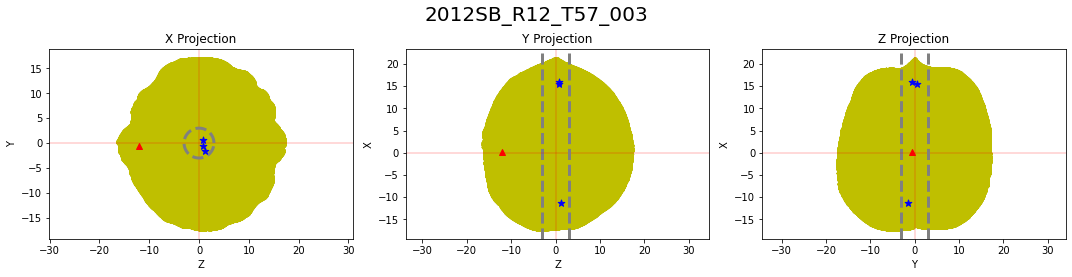

In [63]:
fig, ax = wnut.plot_3Dprojections(mcoords, fname);
ax[0].plot(R*np.cos(rrrange), R*np.sin(rrrange), c='gray', lw=3, ls='--')
ax[1].axvline(R, c='gray', lw=3, ls='--'); ax[1].axvline(-R, c='gray', lw=3, ls='--', zorder=1)
ax[2].axvline(R, c='gray', lw=3, ls='--'); ax[2].axvline(-R, c='gray', lw=3, ls='--', zorder=1)

for i in range(len(mwhere)):
    ax[0].scatter(mcoms[2,mwhere[i]], mcoms[1,mwhere[i]], marker='*', s=50, c='b', alpha=1, zorder=3)
    ax[1].scatter(mcoms[2,mwhere[i]], mcoms[0,mwhere[i]], marker='*', s=50, c='b', alpha=1, zorder=3)
    ax[2].scatter(mcoms[1,mwhere[i]], mcoms[0,mwhere[i]], marker='*', s=50, c='b', alpha=1, zorder=3);
for i in range(len(nwhere)):
    ax[0].scatter(mcoms[2,nwhere[i]], mcoms[1,nwhere[i]], marker='^', s=35, c='r', alpha=1, zorder=2)
    ax[1].scatter(mcoms[2,nwhere[i]], mcoms[0,nwhere[i]], marker='^', s=35, c='r', alpha=1, zorder=2)
    ax[2].scatter(mcoms[1,nwhere[i]], mcoms[0,nwhere[i]], marker='^', s=35, c='r', alpha=1, zorder=2);

In [113]:
imask = np.zeros_like(img).astype(np.bool)
for i in where[mwhere]:
    imask[labels == i] = True

imask = ndimage.binary_dilation(imask, struc3, int(np.ceil(K*.1)))
imask = ndimage.binary_dilation(imask, struc1, int(np.ceil(K*.5)))
interior = shell*imask

In [114]:
test = np.zeros_like(img)
test[shell > 0] += 5
test[interior > 0 ] += 2

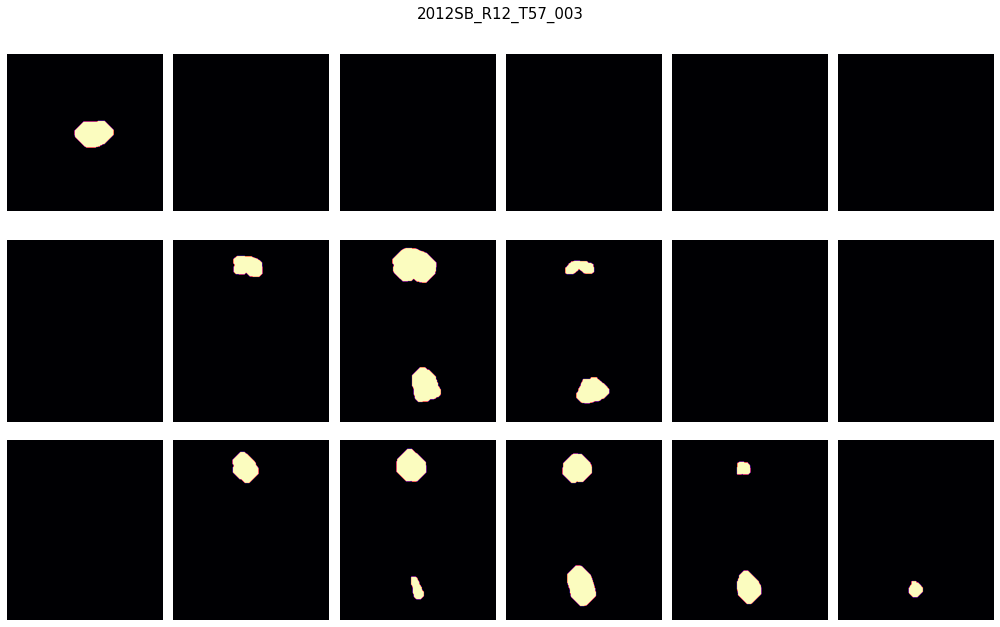

In [115]:
fig, ax = plt.subplots(3,len(ssrange),figsize=(14,9), sharex=False, sharey=False)
for i in range(3):
    for j in range(len(ssrange)):
        ss = Sxyz[len(ssrange)*i + j]
        ax[i,j].imshow(imask[ss], cmap='magma', origin='lower', vmax=1)
        ax[i,j].axis('off')
fig.suptitle(fname, fontsize=fs, color='black');
fig.tight_layout()

In [120]:
filename = wdst + fname + '_shelltype.jpg'
filename

'../hpcc/traditional/2012SB_R12_T57/2012SB_R12_T57_003_seal.jpg'

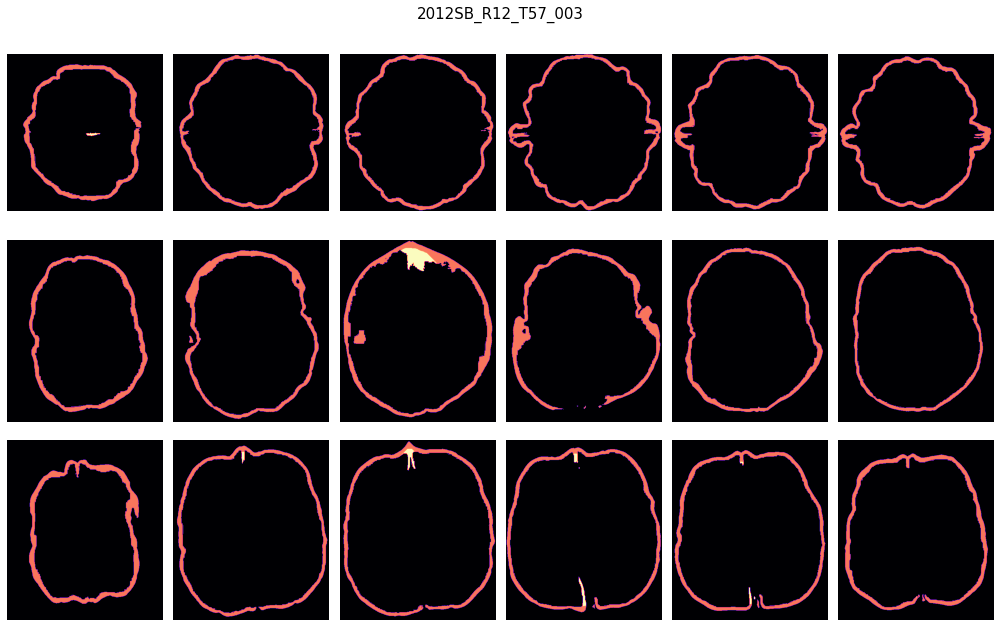

In [121]:
fig, ax = plt.subplots(3,len(ssrange),figsize=(14,9), sharex=False, sharey=False)
for i in range(3):
    for j in range(len(ssrange)):
        ss = Sxyz[len(ssrange)*i + j]
        ax[i,j].imshow(test[ss], cmap='magma', origin='lower', vmax=7)
        ax[i,j].axis('off')
fig.suptitle(fname, fontsize=fs, color='black');
fig.tight_layout()

filename = wdst + fname + '_shelltype.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

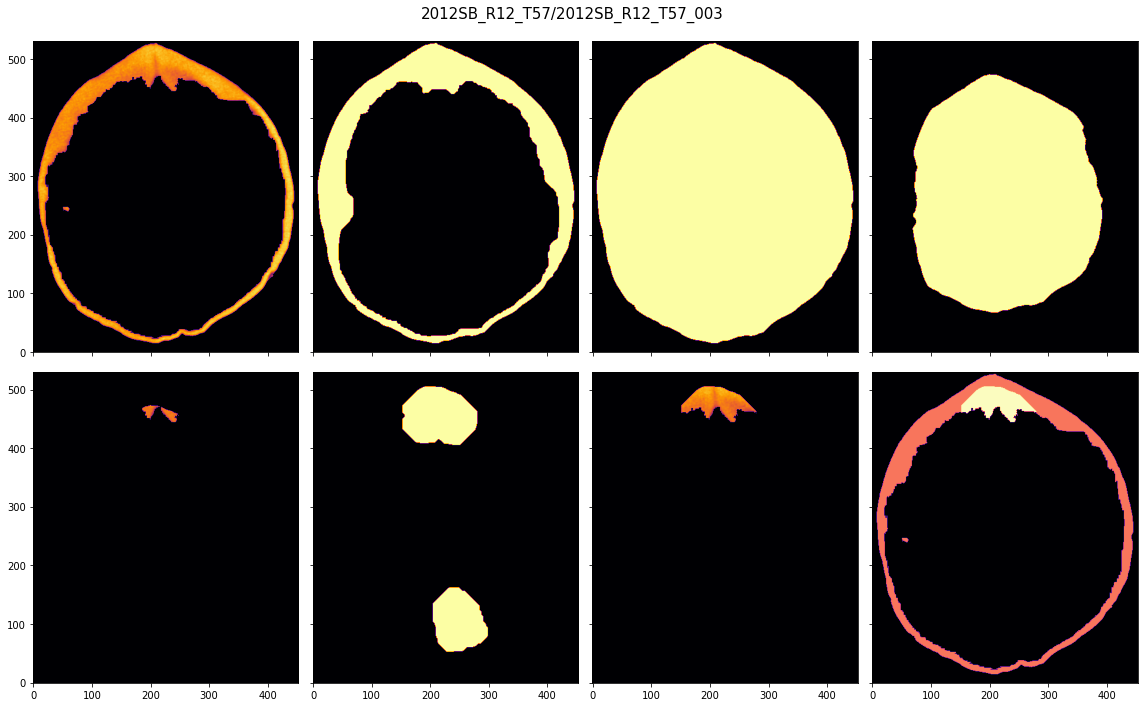

In [117]:
k = 205
ss = np.s_[:,:,k]
ss = np.s_[:,k,:]
#ss = np.s_[k,:,:]

fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()
i = 0;ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1;ax[i].imshow(eshell[ss], cmap='inferno', origin='lower')
i = 2;ax[i].imshow(fshell[ss], cmap='inferno', origin='lower')
i = 3;ax[i].imshow(efill[ss], cmap='inferno', origin='lower')
i = 4;ax[i].imshow(ishell[ss], cmap='inferno', origin='lower', vmax=255)
i = 5;ax[i].imshow(imask[ss], cmap='inferno', origin='lower')
i = 6;ax[i].imshow(interior[ss], cmap='inferno', origin='lower', vmax=255)
i = 7;ax[i].imshow(test[ss], cmap='magma', origin='lower')
fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

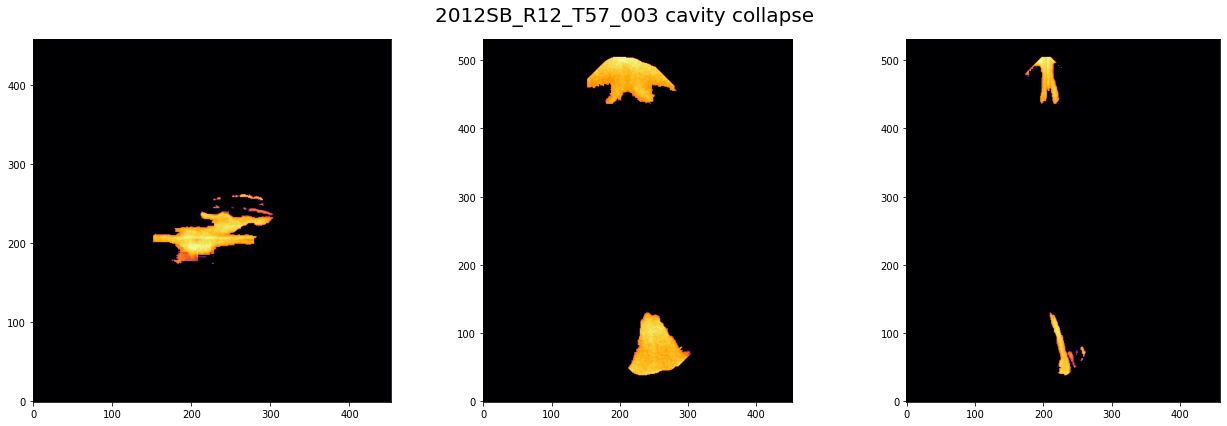

In [122]:
#snaps = wnut.collapse_dimensions(ishell)
#wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

snaps = wnut.collapse_dimensions_max(interior)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

In [ ]:
snaps = wnut.collapse_dimensions_max(test)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

# Diagnostic

In [ ]:
fs = 20
k = 200

fig, ax = plt.subplots(3,5,figsize=(20,12), sharex=True, sharey=True)
for j in range(5):
    ss = Sx[j]
    i = 0
    ax[i,j].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    i = 1
    ax[i,j].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    i = 2
    ax[i,j].imshow(test[ss], cmap='magma', origin='lower', vmax=7)
    ax[i,j].set_xlabel('slice {}'.format(ssrange[j]), fontsize=fs)
    
ax[0,0].set_ylabel('Walnut', fontsize=fs) 
ax[1,0].set_ylabel('Shell', fontsize=fs)
ax[2,0].set_ylabel('Interior', fontsize=fs)
fig.suptitle(fname + ' (X plane)', fontsize=1.25*fs, color='black');
fig.tight_layout()

filename = wdst + fname + '_interior_shell_x.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
#plt.close()

In [ ]:
fs = 20
k = 200

fig, ax = plt.subplots(3,5,figsize=(20,12), sharex=True, sharey=True)
for j in range(5):
    ss = Sy[j]
    i = 0
    ax[i,j].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    i = 1
    ax[i,j].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    i = 2
    ax[i,j].imshow(test[ss], cmap='magma', origin='lower', vmax=7)
    ax[i,j].set_xlabel('slice {}'.format(ssrange[j]), fontsize=fs)
    
ax[0,0].set_ylabel('Walnut', fontsize=fs) 
ax[1,0].set_ylabel('Shell', fontsize=fs)
ax[2,0].set_ylabel('Interior', fontsize=fs)
fig.suptitle(fname + ' (Y plane)', fontsize=1.25*fs, color='black');
fig.tight_layout()

filename = wdst + fname + '_interior_shell_y.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

In [ ]:
fs = 20
k = 200

fig, ax = plt.subplots(3,5,figsize=(20,12), sharex=True, sharey=True)
for j in range(5):
    ss = Sz[j]
    i = 0
    ax[i,j].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    i = 1
    ax[i,j].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    i = 2
    ax[i,j].imshow(test[ss], cmap='magma', origin='lower', vmax=7)
    ax[i,j].set_xlabel('slice {}'.format(ssrange[j]), fontsize=fs)
    
ax[0,0].set_ylabel('Walnut', fontsize=fs) 
ax[1,0].set_ylabel('Shell', fontsize=fs)
ax[2,0].set_ylabel('Interior', fontsize=fs)
fig.suptitle(fname + ' (Z plane)', fontsize=1.25*fs, color='black');
fig.tight_layout()

filename = wdst + fname + '_interior_shell_z.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})